In [2]:
#data load label 1 for red wine,0 for read wine 
import pandas as pd
import numpy as np
red_wine_data1=pd.read_csv("./winequality-red.csv",sep=';')
red_wine_data1=np.array(red_wine_data1)
white_wine_data1=pd.read_csv("./winequality-white.csv",sep=';')
white_wine_data1=np.array(white_wine_data1)
red_wine_label=red_wine_data1[:,11]
red_wine_data=red_wine_data1[:,[0,1,2,3,4,5,6,7,8,9,10]]
white_wine_label=white_wine_data1[:,11]
white_wine_data=white_wine_data1[:,[0,1,2,3,4,5,6,7,8,9,10]]
red_wine_data.shape

(1599, 11)

In [3]:
#data split
from sklearn.model_selection import train_test_split
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(red_wine_data, red_wine_label, test_size=0.35, random_state=42)
X_train_white, X_test_white, y_train_white, y_test_white \
    = train_test_split(white_wine_data, white_wine_label, test_size=0.35, random_state=42)

In [4]:
def LDA_method(dataset,label,n_dim):
    clusters = np.unique(label)
   # print(clusters)
    if n_dim>len(clusters)-1:
        print("error!")
        return
    #cal Sw
    Sw = np.zeros((dataset.shape[1],dataset.shape[1]))
    for i in clusters:
        datai = dataset[label == i]
        datai = datai-datai.mean(0)
        Swi = np.dot(datai.T,datai)
        Sw += Swi
    #cal SB
    SB=np.zeros((dataset.shape[1],dataset.shape[1]))
    for i in clusters:
        m=dataset.mean(0)
        Ni = dataset[label == i].shape[0]
       # print(Ni)
        mi = dataset[label == i].mean(0)  #某个类别的平均值
        SBi = Ni*np.dot((mi - m).T,(mi - m))
        SB += SBi
    S = np.linalg.inv(Sw)*SB
    eigVals,eigVects = np.linalg.eig(S)  #求特征值，特征向量
    eigValInd = np.argsort(eigVals)
    eigValInd = eigValInd[:(-n_dim-1):-1]
    w = eigVects[:,eigValInd]
    data_ndim = np.dot(dataset, w)
    return data_ndim

In [5]:
def PCA_method(dataset,n_dim):
    n=dataset.shape[0]
    m=dataset.mean(0)
    S=np.zeros((dataset.shape[1],dataset.shape[1]))
    for i in range(0,n):
       # print((dataset[i]-m).shape)
        Si=np.outer((dataset[i]-m),(dataset[i]-m).T)
       # print(np.outer((dataset[i]-m),(dataset[i]-m).T).shape)
        S+=Si
    #print(S)
    #print(m)
    eigVals,eigVects=np.linalg.eig(S)
    #print(eigVals)
    indexs_ = np.argsort(-eigVals)[:n_dim]
    picked_eig_values = eigVals[indexs_]
    picked_eig_vector = eigVects[:, indexs_]
    #print(picked_eig_vector)
    data_ndim = np.dot(dataset-m, picked_eig_vector)
   # print(m)
    return data_ndim

In [6]:
#降维前数据分类
#lr using ovsall method
def logclassfy1(dataset,label):
    dataset=pd.DataFrame(dataset)
    dataset['add']=1
    #print(dataset)
    clusters=np.unique(label)
    weight=[]
    #pre process data
    #print(clusters)
    for i in clusters:
        label_i=[]
        for j in range(len(dataset)):
            if label[j]==i:
                label_i.append(1)
               # print(i)
            else:
                label_i.append(0)
            #print(label_i)
        #logistic regression closed-form solution
        data_trans=np.transpose(dataset)
        XXT=np.dot(data_trans,dataset)
        inv=np.linalg.inv(XXT)
        before=np.dot(inv,data_trans)
        beta=np.dot(before,label_i)
        weight.append(beta)
    return weight

In [7]:
#red_wine_train
weight_red=logclassfy1(X_train_red,y_train_red)
weight_red=np.array(weight_red)

In [8]:
'''save the test_target'''
import pandas as pd
def tocsv(outputs,x,label,method):
    test=pd.DataFrame(data=outputs)
    test.to_csv('./{}dim-{}-{}.csv'.format(x,label,method),index=False,header=None) 

In [9]:
def judgeF(x):
    return 1.0/(1.0+np.exp(-x))
def envlute(para,valdata):
    valdata=(pd.DataFrame(valdata))
    valdata['add']=1
    valdata=np.array(valdata)
    #print(valdata)
    activations = valdata.dot(para.T)
   # print(activations)
    p = np.empty((len(activations)))
    for i in range(0, len(activations)):  
        idx = np.argmax(judgeF(activations[i]))
        p[i] = idx+3
    return p
ans_red=envlute(weight_red,X_test_red)
count=0
for i in range(len(ans_red)):
    if ans_red[i]==y_test_red[i]:
        count+=1
print(count/len(ans_red))

0.5642857142857143


In [10]:
#white_wine_train
weight_white=logclassfy1(X_train_white,y_train_white)
weight_white=np.array(weight_white)
ans_white=envlute(weight_white,X_test_white)
count=0
for i in range(len(ans_white)):
    if ans_white[i]==y_test_white[i]:
        count+=1
print(count/len(ans_white))

0.5329446064139942


In [11]:
#降维后进行分析PCA
acc_P_R=[]
acc_P_W=[]
for i in range(11):
    dim=11-i
    data_dim_red=PCA_method(red_wine_data,dim)
    X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(data_dim_red, red_wine_label, test_size=0.35, random_state=42)
    weight_red=logclassfy1(X_train_red,y_train_red)
    weight_red=np.array(weight_red)
    ans_red=envlute(weight_red,X_test_red)
    count=0
    for i in range(len(ans_red)):
        if ans_red[i]==y_test_red[i]:
            count+=1
    print("red,dim={},acc={}".format(dim,count/len(ans_red)))
    acc_P_R.append(count/len(ans_red))
    tocsv(data_dim_red,dim,'red','PCA')
    data_dim_white=PCA_method(white_wine_data,dim)
    X_train_white, X_test_white, y_train_white, y_test_white \
    = train_test_split(data_dim_white, white_wine_label, test_size=0.35, random_state=42)
    weight_white=logclassfy1(X_train_white,y_train_white)
    weight_white=np.array(weight_white)
    ans_white=envlute(weight_white,X_test_white)
    count=0
    for i in range(len(ans_white)):
        if ans_white[i]==y_test_white[i]:
            count+=1
    print("white,dim={},acc={}".format(dim,count/len(ans_white)))
    acc_P_W.append(count/len(ans_white))
    tocsv(data_dim_white,dim,'white','PCA')

red,dim=11,acc=0.5642857142857143
white,dim=11,acc=0.5329446064139942
red,dim=10,acc=0.5642857142857143
white,dim=10,acc=0.5230320699708455
red,dim=9,acc=0.5607142857142857
white,dim=9,acc=0.5265306122448979
red,dim=8,acc=0.5517857142857143
white,dim=8,acc=0.4897959183673469
red,dim=7,acc=0.5428571428571428
white,dim=7,acc=0.49387755102040815
red,dim=6,acc=0.5464285714285714
white,dim=6,acc=0.5061224489795918
red,dim=5,acc=0.5464285714285714
white,dim=5,acc=0.5090379008746355
red,dim=4,acc=0.4928571428571429
white,dim=4,acc=0.5037900874635568
red,dim=3,acc=0.4928571428571429
white,dim=3,acc=0.446064139941691
red,dim=2,acc=0.4928571428571429
white,dim=2,acc=0.4501457725947522
red,dim=1,acc=0.4714285714285714
white,dim=1,acc=0.45481049562682213


In [12]:
#降维后进行分析LDA
acc_L_R=[]
acc_L_W=[]
for i in range(5):
    dim=5-i
    data_dim_red=LDA_method(red_wine_data,red_wine_label,dim)
    X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(data_dim_red, red_wine_label, test_size=0.35, random_state=42)
    weight_red=logclassfy1(X_train_red,y_train_red)
    weight_red=np.array(weight_red)
    ans_red=envlute(weight_red,X_test_red)
    count=0
    for i in range(len(ans_red)):
        if ans_red[i]==y_test_red[i]:
            count+=1
    print("red,dim={},acc={}".format(dim,count/len(ans_red)))
    acc_L_R.append(count/len(ans_red))
    tocsv(data_dim_white,dim,'red','LDA')
for i in range(6):
    dim=6-i
    data_dim_white=LDA_method(white_wine_data,white_wine_label,dim)
    X_train_white, X_test_white, y_train_white, y_test_white \
        = train_test_split(data_dim_white, white_wine_label, test_size=0.35, random_state=42)
    weight_white=logclassfy1(X_train_white,y_train_white)
    weight_white=np.array(weight_white)
    ans_white=envlute(weight_white,X_test_white)
    count=0
    for i in range(len(ans_white)):
        if ans_white[i]==y_test_white[i]:
            count+=1
    print("white,dim={},acc={}".format(dim,count/len(ans_white)))
    acc_L_W.append(count/len(ans_white))
    tocsv(data_dim_white,dim,'white','LDA')

red,dim=5,acc=0.475
red,dim=4,acc=0.4660714285714286
red,dim=3,acc=0.46964285714285714
red,dim=2,acc=0.44107142857142856
red,dim=1,acc=0.41785714285714287
white,dim=6,acc=0.47580174927113705
white,dim=5,acc=0.4752186588921283
white,dim=4,acc=0.46822157434402334
white,dim=3,acc=0.46588921282798834
white,dim=2,acc=0.4524781341107872
white,dim=1,acc=0.4524781341107872


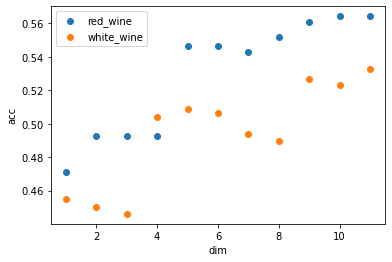

In [13]:
import matplotlib.pyplot as plt
plt.scatter(range(11,0,-1),acc_P_R)
plt.xlabel("dim")
plt.ylabel("acc")
plt.scatter(range(11,0,-1),acc_P_W)   
plt.legend(["red_wine", "white_wine"])

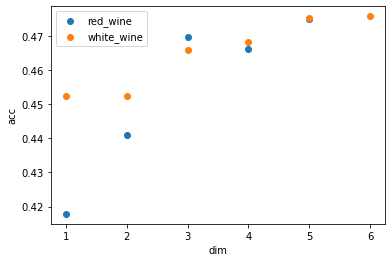

In [14]:
plt.scatter(range(len(acc_L_R),0,-1),acc_L_R)
plt.scatter(range(len(acc_L_W),0,-1),acc_L_W)
plt.xlabel("dim")
plt.ylabel("acc")
plt.legend(["red_wine", "white_wine"])